In [96]:
from datasets import load_dataset


pic_dataset = load_dataset("PiC/phrase_similarity")


train_data = pic_dataset['train']
validation_data = pic_dataset['validation']
test_data = pic_dataset['test']


In [97]:
import numpy as np 
import pandas as pd 
import gensim
import keras
import nltk.corpus
from nltk.corpus import brown

In [98]:
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     /Users/harpreetsingh/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [99]:
nltk.download('brown')

[nltk_data] Downloading package brown to
[nltk_data]     /Users/harpreetsingh/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [100]:
class BrownCorpus(object):
    def __init__(self):
        self.brown =  nltk.corpus.LazyCorpusLoader('brown', nltk.corpus.CategorizedTaggedCorpusReader, r'c[a-z]\d\d',
                                                    cat_file='cats.csv', tagset='brown', encoding="ascii")
    def __iter__(self):
        for (tag,doc) in enumerate(self.brown.paras()):
            yield gensim.models.doc2vec.TaggedDocument(sum(doc,[]),[tag])
            
model = gensim.models.doc2vec.Doc2Vec(BrownCorpus(),
                                      dm_concat=1)

In [101]:
def vectorize_cell(cell):
    return model.infer_vector(list(gensim.utils.tokenize(cell)))

def vectorize(data):
    return np.vstack([np.concatenate([vectorize_cell(row[cell])
                                      for cell in ('phrase1','phrase2')])
                     for row in data])

In [102]:
training_vectors = vectorize(train_data)
training_vectors
np.array(training_vectors).shape

(7004, 200)

In [103]:
predictor = keras.models.Sequential([keras.layers.Dense(100,
                                                       input_shape=(200,),
                                                       activation='relu'),
                                     keras.layers.Dense(100,
                                                       activation='relu'),
                                     keras.layers.Dense(1,
                                                       activation='sigmoid')])
predictor.compile(optimizer='sgd',
                  loss='binary_crossentropy',metrics=['accuracy'])


In [104]:
col_to_predict = train_data['label']
col_to_predict = np.ravel(col_to_predict)

In [105]:

predictor.fit(training_vectors,  col_to_predict, epochs=100)

Epoch 1/100
219/219 [==============================] - 0s 449us/step - loss: 0.6932 - accuracy: 0.4946
Epoch 2/100
219/219 [==============================] - 0s 405us/step - loss: 0.6932 - accuracy: 0.4909
Epoch 3/100
219/219 [==============================] - 0s 421us/step - loss: 0.6932 - accuracy: 0.4926
Epoch 4/100
219/219 [==============================] - 0s 519us/step - loss: 0.6932 - accuracy: 0.5019
Epoch 5/100
219/219 [==============================] - 0s 403us/step - loss: 0.6932 - accuracy: 0.4967
Epoch 6/100
219/219 [==============================] - 0s 406us/step - loss: 0.6932 - accuracy: 0.4940
Epoch 7/100
219/219 [==============================] - 0s 409us/step - loss: 0.6932 - accuracy: 0.4991
Epoch 8/100
219/219 [==============================] - 0s 406us/step - loss: 0.6932 - accuracy: 0.4924
Epoch 9/100
219/219 [==============================] - 0s 411us/step - loss: 0.6931 - accuracy: 0.5017
Epoch 10/100
219/219 [==============================] - 0s 419us/step - l

In [106]:
test_embeddings = vectorize(test_data)
test_embeddings

array([[-7.4388310e-03,  1.5384851e-03,  5.2745198e-03, ...,
        -1.4884687e-03,  3.7267196e-03, -1.1773572e-03],
       [ 1.4068283e-03, -2.9626705e-03, -8.3598099e-04, ...,
        -3.0590424e-03,  1.4305389e-03,  7.6663709e-05],
       [ 2.7449734e-03,  5.0413497e-03,  5.0608232e-03, ...,
        -1.2750319e-03,  2.2138278e-03, -8.4214256e-04],
       ...,
       [-5.1051434e-03, -6.6496129e-04, -4.7095628e-03, ...,
         3.1497872e-03, -3.3479696e-03,  1.2919494e-03],
       [-3.9457614e-03, -4.6404894e-03, -4.1729175e-03, ...,
         7.4822182e-04,  6.4307945e-03,  7.0332746e-05],
       [-2.5317159e-03, -5.3445557e-03, -7.2596190e-03, ...,
         6.1977110e-03, -4.2854198e-03, -8.0721115e-04]], dtype=float32)

In [107]:
test_to_predict = test_data['label']
test_to_predict = np.array(test_to_predict)
test_to_predict

array([0, 0, 1, ..., 0, 0, 1])

In [108]:
predictor.evaluate(test_embeddings, np.ravel(test_to_predict), verbose = 1)

63/63 [==============================] - 0s 424us/step - loss: 0.6933 - accuracy: 0.4940


[0.6932888627052307, 0.49399998784065247]

In [109]:
predictor.predict(test_embeddings)

63/63 [==============================] - 0s 354us/step


array([[0.49775106],
       [0.49718374],
       [0.49685827],
       ...,
       [0.4991798 ],
       [0.49504477],
       [0.49689403]], dtype=float32)

In [110]:
results = pd.DataFrame(predictor.predict(test_embeddings),
                       index=range(test_data.num_rows),
                       columns=['label'])


63/63 [==============================] - 0s 333us/step


In [111]:
results

,label
0,0.497751
1,0.497184
2,0.496858
3,0.498360
4,0.497483
...,...
1995,0.499239
1996,0.498444
1997,0.499180
1998,0.495045


In [112]:
new_vector = np.array(results['label'])
for i in range(len(new_vector)):
    print(i+1,new_vector[i], test_to_predict[i])

1 0.49775106 0
2 0.49718374 0
3 0.49685827 1
4 0.4983596 0
5 0.49748257 0
6 0.49925417 0
7 0.49701393 0
8 0.4973445 1
9 0.49618953 1
10 0.49860567 0
11 0.4986779 0
12 0.49872974 0
13 0.4984532 0
14 0.49792323 0
15 0.49825293 0
16 0.49824205 1
17 0.4964227 1
18 0.49621433 0
19 0.49777067 0
20 0.4980237 0
21 0.4971404 0
22 0.4995041 1
23 0.4987223 0
24 0.49695075 1
25 0.49771473 1
26 0.49731937 1
27 0.49900866 0
28 0.4974525 1
29 0.49675962 0
30 0.4977895 1
31 0.49645802 1
32 0.4976329 1
33 0.49653593 0
34 0.49766976 1
35 0.49877274 0
36 0.4979035 0
37 0.49857613 0
38 0.49820974 1
39 0.49793494 1
40 0.49715227 1
41 0.49919885 1
42 0.49760833 0
43 0.49847344 0
44 0.49896494 0
45 0.4971006 1
46 0.49899605 0
47 0.49766374 0
48 0.49819633 1
49 0.49716213 1
50 0.49829605 1
51 0.4990091 1
52 0.49692205 1
53 0.49800315 1
54 0.49661955 0
55 0.4990991 0
56 0.49563858 0
57 0.49903637 1
58 0.49802166 0
59 0.49860293 0
60 0.4997504 1
61 0.4979503 1
62 0.4981969 1
63 0.49675277 1
64 0.4975758 0
65 0.

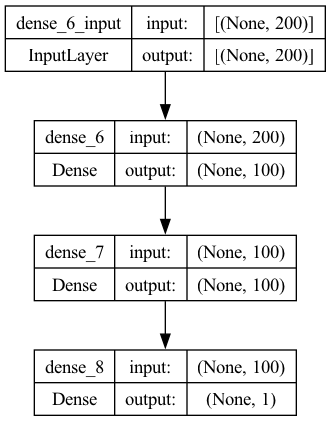

In [113]:
from keras.utils import plot_model
plot_model(predictor, to_file='/tmp/model.png', show_shapes=True,)

Now trying WMD

In [114]:
from word_mover_distance import model


In [116]:
my_model = model.WordEmbedding(model_fn="glove.6B/glove.6B.100d.txt")
wmdistance=[]
for row in train_data:
    s1 = row['phrase1'].lower().split()

    s2 = row['phrase2'].lower().split()

    wmdistance.append( my_model.wmdistance(s1, s2))

In [ ]:
for i in range(len(wmdistance)):
    print(i+1, wmdistance[i]-new_vector[i], test_to_predict[i])

In [117]:
gg = wmdistance.copy()
s = 5.3 # Threshold
for i in range(len(wmdistance)):
    if(wmdistance[i]>s):
        gg[i] = 1
    else: gg[i] = 0
print(gg.count(0))
print(list(col_to_predict).count(0))

3532
3502


In [118]:
wmdistance=[]
for row in test_data:
    s1 = row['phrase1'].lower().split()

    s2 = row['phrase2'].lower().split()

    wmdistance.append( my_model.wmdistance(s1, s2))

In [119]:
gg = wmdistance.copy()
s = 5.3 # Threshold
for i in range(len(wmdistance)):
    if(wmdistance[i]>s):
        gg[i] = 1
    else: gg[i] = 0
print(gg.count(0))
print(list(test_to_predict).count(0))

997
1000


In [120]:
cnt = 0
for i in range(len(wmdistance)):
    if(gg[i]==test_to_predict[i]):
        cnt+=1
cnt/len(list(test_to_predict))

0.4845

Hence we have 997 equal values so our value on test set is 0.48, which is less or near to 0.5 hence we can't surely tell if it is a paraphrase or not

In [83]:
l1 = [np.concatenate([vectorize_cell(row[cell]) for cell in ('phrase1',)]) for row in test_data]
l2 = [np.concatenate([vectorize_cell(row[cell]) for cell in ('phrase2',)]) for row in test_data]
l3 = [np.concatenate([vectorize_cell(row[cell])
                                      for cell in ('phrase1','phrase2')])
                     for row in test_data]

In [89]:
# print(l1[0], l2[0], test_embeddings[0])
# print(np.array(l1).shape, np.array(l2).shape, test_embeddings.shape)
l1 = []
l2 = []
for row in test_embeddings:
    l1.append( row[:100])
    l2 .append(row[100:])


In [94]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = []
for vec1, vec2 in zip(l1, l2):
    similarity = cosine_similarity([vec1], [vec2])[0][0]
    similarities.append(similarity)
